In [3]:
library(slingshot)
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library('tidyverse')
quiet_library("hise")
quiet_library('data.table')
quiet_library('parallel')
quiet_library('dplyr')
library(anndata)
options(future.globals.maxSize = 1000 * 1024^5)
Sys.setenv( TZ="Etc/GMT+1" )
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(viridis)
library(ggrastr)

pal <- c(RColorBrewer::brewer.pal(9, "Set1"), RColorBrewer::brewer.pal(8, "Set2"))
set.seed(123)


In [4]:
sce<-readRDS("02_TEAseq_CD8_T_cells_traj/sce_processed.RDS")
scRNA_QC<-read.csv("02_TEAseq_CD8_T_cells_traj/scRNA_obs.csv")

In [5]:
pseudotime <- slingPseudotime(sce, na = FALSE)


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


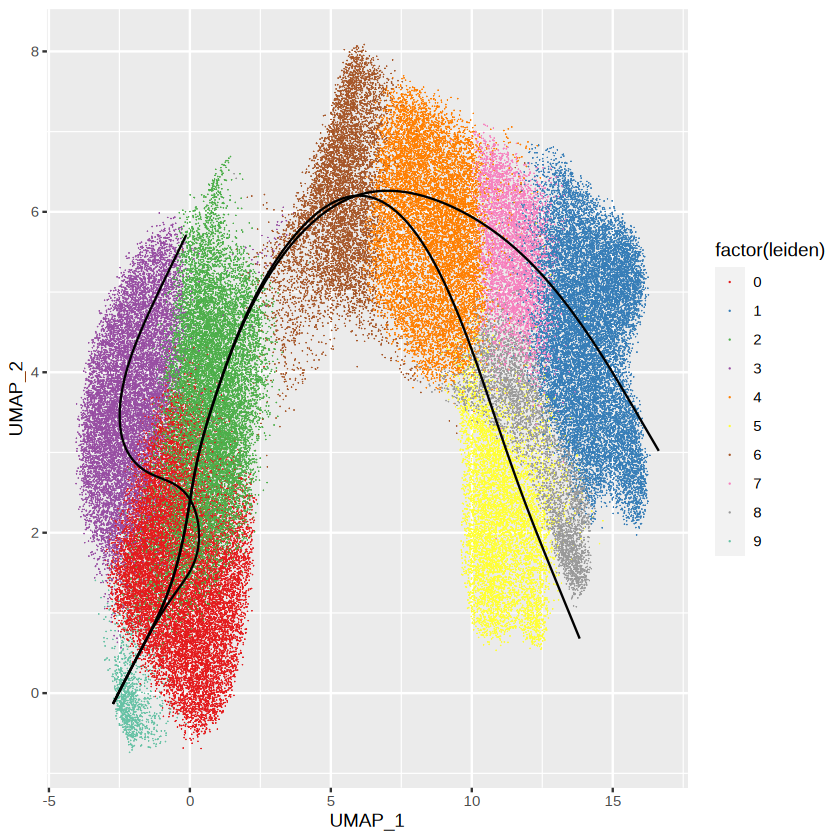

In [6]:

sce_dd  <- SlingshotDataSet(sce)
curves  <- sce_dd@curves
curve_df <- do.call(rbind, lapply(seq_along(curves), function(i) {
  d <- as.data.frame(curves[[i]]$s)
  d$lineage <- paste0("Lineage", i)
  d
}))

df <- scRNA_QC

p <- ggplot(df, aes(UMAP_1, UMAP_2, color = factor(leiden))) +

  geom_point_rast(size = 0.05, shape = 16)  +
  scale_color_manual(values = pal) +
  geom_path(
    data          = curve_df,
    mapping       = aes(UMAP_1, UMAP_2, group = lineage),
    inherit.aes   = FALSE,
    size          = 0.5
  )+ scale_fill_discrete(guide="none")
p

ggsave("FigureD-1.pdf", p, width = 100/25.4, height = 60/25.4)

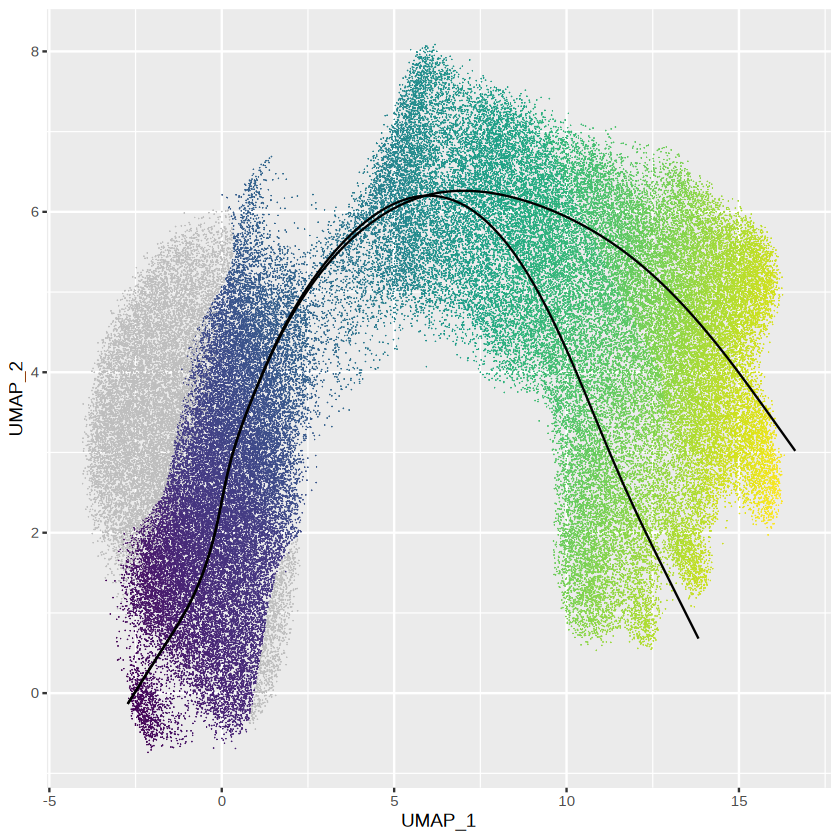

In [7]:
pal <- viridis(100)
DD <- SlingshotDataSet(sce)
lineages_to_plot <- c("Lineage1", "Lineage2")

pseudotime_all <- slingPseudotime(DD)
combined_pt <- pseudotime_all[, lineages_to_plot[1]]
combined_pt[is.na(combined_pt)] <- pseudotime_all[, lineages_to_plot[2]][is.na(combined_pt)]

df2 <- scRNA_QC
df2$pseudotime <- combined_pt

curve_df <- do.call(rbind, lapply(seq_along(DD@curves[lineages_to_plot]), function(i) {
  d <- as.data.frame(DD@curves[[ lineages_to_plot[i] ]]$s)
  d$lineage <- lineages_to_plot[i]
  d
}))

p <- ggplot(df2, aes(UMAP_1, UMAP_2)) +
  geom_point_rast(aes(color = pseudotime), size = 0.05, shape = 16) +
  scale_color_gradientn(colors = pal, na.value = "grey", guide = "none") +
  geom_path(
    data        = curve_df,
    mapping     = aes(UMAP_1, UMAP_2, group = lineage),
    inherit.aes = FALSE,
    size        = 0.5
  )
p
ggsave("FigureD-2.pdf", p, width = 6, height = 6, dpi = 600)